# **Dynamic Time Warping Lab - TSIA 206 - Hugo QUENIAT**

# Dynamic Time Warping for Speech Recognition
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [269]:
import os
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

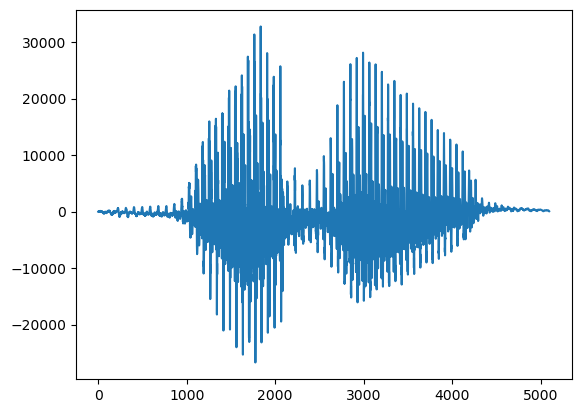

In [270]:
from scipy.io import wavfile

file_path = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

In [271]:
print(np.fft.ifft(np.log(np.abs(np.fft.fft(wav_data)))).shape)

(5098,)


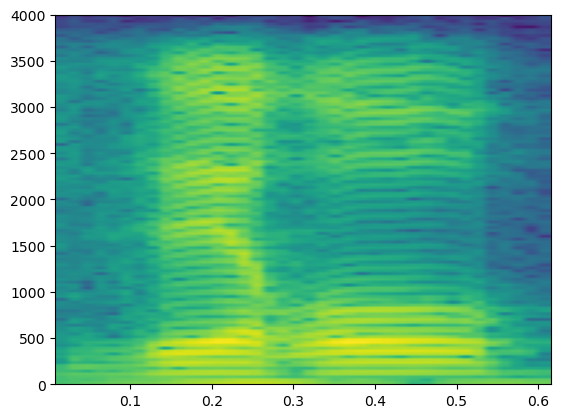

In [272]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

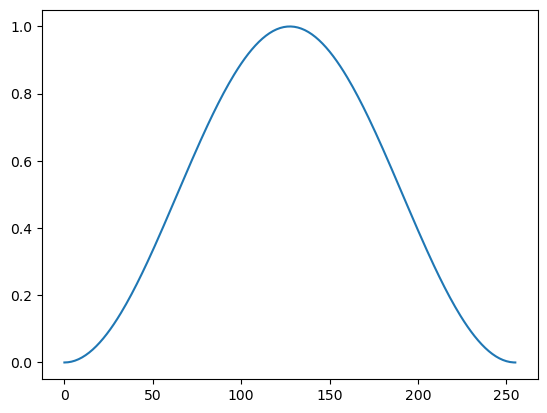

In [273]:
plt.plot(np.hanning(256))

## Speech Feature Extraction



Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [274]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    window = np.hanning(window_size)
    N_segments = int(np.floor((len(wav_data) - window_size) / window_shift) + 1)
    cepstral_vectors = np.zeros((N_segments, cepstral_order))
    for i in range(N_segments):
        segment = wav_data[i * window_shift : i * window_shift + window_size]
        segment = segment * window
        segment = np.fft.fft(segment)
        segment = np.fft.ifft(np.log(np.abs(segment))).real
        cepstral_vectors[i, :] = segment[:cepstral_order]
        
    
    return cepstral_vectors

In [275]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [276]:
5098 // 128 - 1

38

In [277]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $C (l_X \times l_Y)$ such that $C(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $D (l_X \times l_Y)$ such that $D(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $D(i,i)$ then $D(i+1,i), \dots D(l_X,i)$ and $D(i,i+1), D(i,i+2), \dots D(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```D```).

In [278]:
from scipy.spatial.distance import cdist


def predecessor(D,C,B,i,j,wd,wh,wv):
    
    # Calculation of the cumulative distances around the node D[j,i] through the predecessors
    corner = D[i-1,j-1] + wd * C[i,j]
    left = D[i,j-1] + wv * C[i,j]
    top = D[i-1,j] + wh * C[i,j]
    
    # Selection of the minimum, the best predecessor
    dist = min(corner, left, top)
    
    # Store the cumulative distance
    D[i,j] = dist
    
    # Store the predecessor
    if dist == corner:
        B[i,j] = [i-1,j-1]
    elif dist == left:
        B[i,j] = [i,j-1]
    else :
        B[i,j] = [i-1,j]
    

def time_alignment(x, y, gamma):
    
	# Length of the two sequences
    lx = len(x)
    ly = len(y)
    
    # Calculation of the similitary matrix
    C = np.zeros((lx,ly))
    for i in range(lx):
        for j in range(ly):
            C[i,j] = np.linalg.norm(x[i] - y[j])
    
    # Initializaiton of the weights
    wd, wh, wv = gamma, 1 , 1
            
    # Initialization of the cumulative distance matrix
    D = np.zeros((lx,ly))
    sum = 0
    
    # Initialization of the backtrack matrix
    B = np.zeros((lx,ly,2))
    
    for i in range(0,lx):
        sum += C[i,0]
        D[i,0] = sum
    sum = 0
    for j in range(0,ly):
        sum += C[0,j]
        D[0,j] = sum
    # Calculation of the cumulative distance matrix
    for i in range(1, min(lx,ly)):
        for j in range(i,lx):
            predecessor(D,C,B,j,i,wd,wh,wv)
        for j in range(i+1,ly):
            predecessor(D,C,B,i,j,wd,wh,wv)
        
    # Backtracking
    i , j = lx-1, ly-1
    M = [[i,j]]
    while i > 0 and j > 0:
        i_pred, j_pred = B[i,j]
        M.append([i_pred,j_pred])
        i , j = int(i_pred) , int(j_pred)
    
    # Adding the first node, starting point    
    M.append([0,0])
    
    # Reversing the path to get the right order
    M = np.array(M[::-1])
    
    # The distance is the cumulative distance at the end of the path
    distance = D[lx-1,ly-1]
    
    return D, M, distance

**Explanation of the algorithm**:

We compute the cumulative distance matrix by evolving through the matrix from the top left corner to the top right, when we beginning each loop, we compute D[i,i] and then the column below and then the line on the right. This way, we ensure that at each computation we have the actual value of every D[i,j] we need to compute the next ones (the one on top, the one on the left and the one in the top left corner).

In [279]:
# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = "./SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

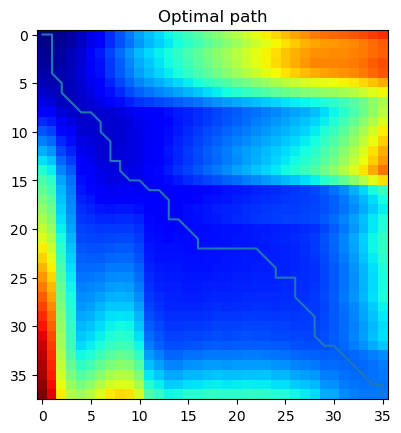

Cost of the optimal path: 24.053201219759252


In [280]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(D, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0])
plt.show()
print("Cost of the optimal path:", distance)

### Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

#### **1.**

In [281]:
# Finding the closest repetition to the reference

# reference
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)

# Matrix to store the distances
dist = np.zeros(11)
for i in range(2,13):
    # Load the repetition
    file_path = "./SIG/SIG_Rep_" + str(i) + "_Number_0.wav"
    sample_rate, wav_data = wavfile.read(file_path)
    cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
    
    # Calculate the distance
    _, _, distance = time_alignment(cepstral_vectors_1, cepstral_vectors, gamma=2)
    
    # Store the distance
    dist[i-2] = distance

print("Closest repetition:", np.argmin(dist) + 2)
print("Distance:", np.min(dist))
print("Furthest repetition:", np.argmax(dist) + 2)
print("Distance:", np.max(dist))

Closest repetition: 8
Distance: 20.796606433271872
Furthest repetition: 12
Distance: 30.470442966413373


**Are the performances satisfactory ?**

**Answer**:
So I computed the optimal path of each pronunciation of the first word to check which is the closest. Futhermore, I also focused on the furthest so that I have a good basis to assess the performances through my own ear. Thus, I actually listened to those two the audio 8 and audio 12. I can hear quite distinctly a lower pitch in the audio 8, which sticks better to the reference (audio 1) whereas the audio 12 had a higher pitch. So I would say that the performances are satisfactory even though the difference was still quite subtle.

#### **2.**

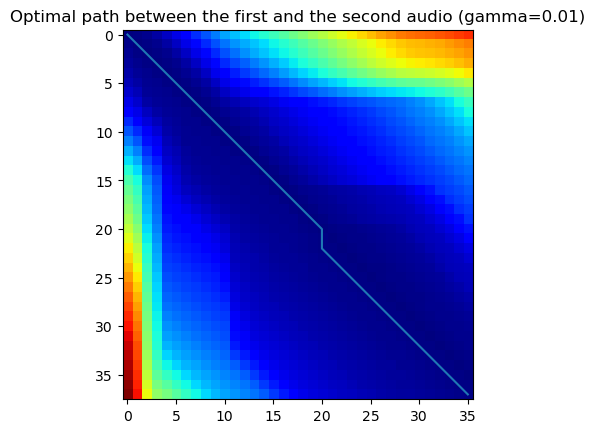

Cost of the optimal path between the first and the second audio: 1.359134256101871
Closest repetition: 11
Distance: 1.213030054762973
Furthest repetition: 12
Distance: 3.454609585796923


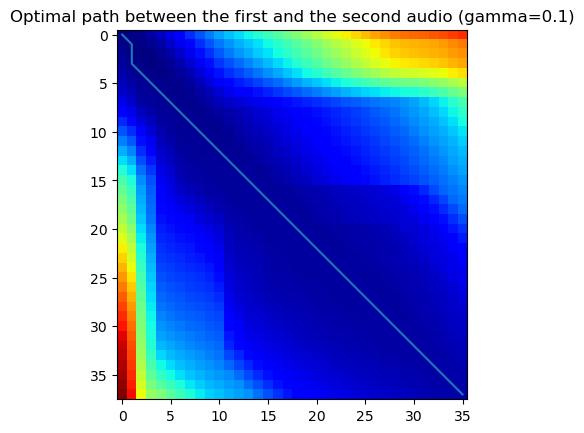

Cost of the optimal path between the first and the second audio: 4.089513787066688
Closest repetition: 5
Distance: 2.881119081924584
Furthest repetition: 12
Distance: 5.311202972445226


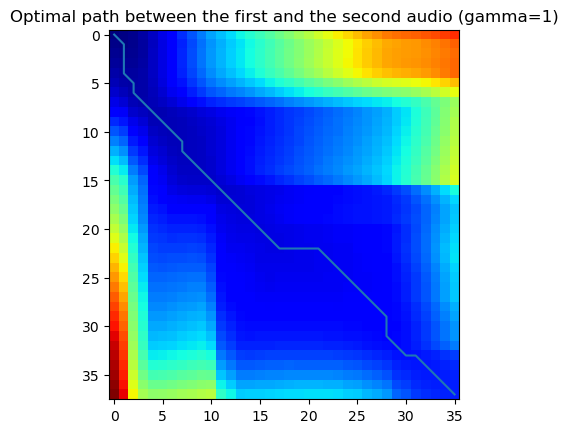

Cost of the optimal path between the first and the second audio: 15.514824134680982
Closest repetition: 8
Distance: 12.946967541998927
Furthest repetition: 12
Distance: 20.591578587864603


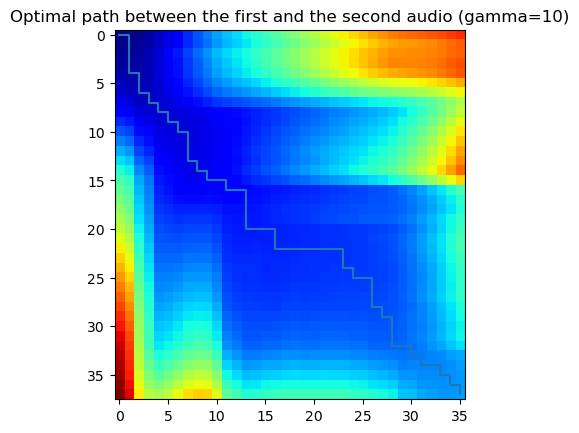

Cost of the optimal path between the first and the second audio: 27.230301517802324
Closest repetition: 8
Distance: 24.09611085429479
Furthest repetition: 12
Distance: 34.06156916895054


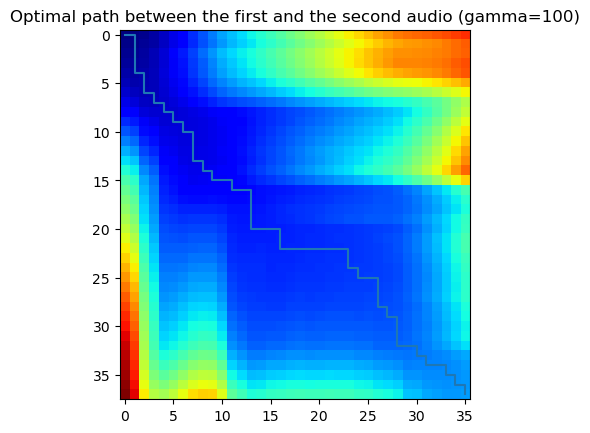

Cost of the optimal path between the first and the second audio: 27.230301517802324
Closest repetition: 8
Distance: 24.09611085429479
Furthest repetition: 12
Distance: 34.06156916895054


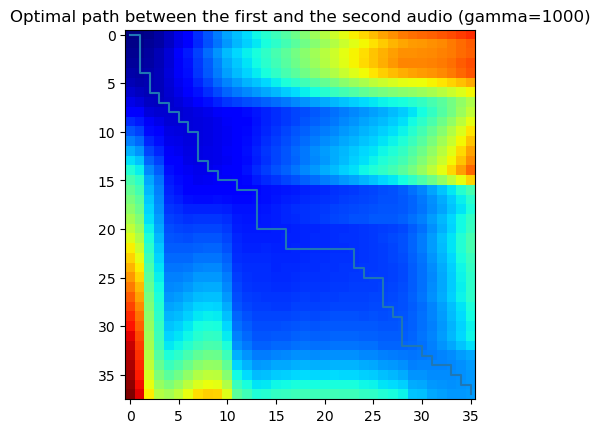

Cost of the optimal path between the first and the second audio: 27.230301517802324
Closest repetition: 8
Distance: 24.09611085429479
Furthest repetition: 12
Distance: 34.06156916895054


In [282]:
# Compute and plot the alignment path for several values of gamma

# Example of time alignment
file_path_1 = "./SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

gammas = [0.01, 0.1, 1, 10, 100, 1000]

for gamma in gammas:
    
    # Compute the distance and the optimal path for the current value of gamma
    D, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma)
    
    # Example of visualization of the optimal path
    M = np.array(M)
    plt.imshow(D, cmap='jet')
    plt.title(f"Optimal path between the first and the second audio (gamma={gamma})")
    plt.plot(M[:, 1], M[:, 0])
    plt.show()
    print("Cost of the optimal path between the first and the second audio:", distance)
    
    # Compute the distances for other repetitions and show closest and furthest repetitions
    dist = np.zeros(11)
    for i in range(2,13):
        file_path = "./SIG/SIG_Rep_" + str(i) + "_Number_0.wav"
        sample_rate, wav_data = wavfile.read(file_path)
        cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
        _, _, distance = time_alignment(cepstral_vectors_1, cepstral_vectors, gamma=gamma)
        dist[i-2] = distance
    print("Closest repetition:", np.argmin(dist) + 2)
    print("Distance:", np.min(dist))
    print("Furthest repetition:", np.argmax(dist) + 2)
    print("Distance:", np.max(dist))

**What is the influence of the γ choice**

**Answer**:

With the evolution of the plots, we clearly see that the lower the $\gamma$ the more the path is diagonal. This is due to the fact that the diagonal will become the cheapest path at almost each turn since the diagonal weight will be very low. When the $\gamma$ is high, the algorithm will explore paths that are not diagonal. This is due to the fact that the diagonal will be more expensive than the other paths. Thus, the optimum path will be more likely to be a non-diagonal one.

The obtained distances do vary a lot depnding on the value of gamma. However, apart from the first test value which is a very low value for $\gamma$ and where we find a different closest repetition, we always find the same closest and furthest repititions. Thus, we can say that the value of $\gamma$ does not have a significant influence on the obtained distance, it changes its value but not its order.


#### **3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors?**

**Answer**: 

When using the Euclidean distance, we assume that this distance is a good measure of the proximity of ceptral vectors. It means that two acoustic sequences that are close in terms of pronunciation would have ceptral vectors that are close in terms of Euclidean distance (are close when considered as elements of the Euclidean space).

However, this hypothesis is not necessarily true. Indeed, two acoustic sequences that are close in terms of pronunciation could have ceptral vectors that are far from each other in terms of Euclidean distance. This is due to the fact that the Euclidean distance may not be a good measure of the proximity of ceptral vectors. Indeed, each coordinate has the same weight in the euclidean distance whereas the differences between ceptral vectors may be more important on some coordinates than on others because the differences can come from either pronunciation, emphasis, pitch, voice characteristics, etc.

A solution could be to study in depth the cepstral vectors and their differences through a sample of audios. Thus, we could statistically establish a weighting system to make sure that the computation of the distance captures the actual similarities that we can hear.

To do so, we can analyze the aligned data and especially the distribution of each coordinate of the ceptral vectors. Thus we can acquire knowledge on the discrimination capacity of each coordinate of the ceptral vectors (we have several words). Thus, we use this knowledge to weight highly the coordinates that are severely discriminative and less the ones that are not. This way, we can have a better measure of the proximity of ceptral vectors.

## Evaluation of Speech Recognition

The goal of this part is to implement an evaluation strategy in order to check how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. Ideally, we would need to rotate the reference/unknown sets to perform cross-validation - but we can work with a random choice of only one reference for each number to simplify the setup. 
To do so, write a function ```classification```. For example, you can use the following formalism : 

```[confusion, accuracy] = classification(vectors, gamma)```

- ```vectors``` contains all the cepstral vectors for the signals in the chosen dataset. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.


- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate (averaged over cross-validation experiments if used).

In [283]:
# Establishing the reference set

random.seed(10)


reference = []

# We choose 10 random repetitions that will be used as reference
index = random.sample(range(1, 13), 10)


for i in range(0,10):
    file_path = "./SIG/SIG_Rep_" + str(index[i]) + "_Number_" + str(i) + ".wav"
    sample_rate, wav_data = wavfile.read(file_path)
    cepstral_vectors = feature_extraction(
    wav_data, window_size, window_shift, cepstral_order)
    reference.append(cepstral_vectors)

In [284]:
# Predict the class of a new figure using the reference set

def classification(vectors, gamma):
    n_classes = 10
    
    # Matrix to store results, each row corresponds to a true figure and each column to a predicted figure
    confusion_matrix = np.zeros((n_classes, n_classes))
    
    # Loop through the vectors to be classified
    for to_be_classified in vectors:
        
        # True figure is the actual number pronunced
        true_figure , vector = to_be_classified
        
        min_dist = float('inf')
        prediction = -1
        
        # Test against each reference
        for i in range(n_classes):
            _, _, distance = time_alignment(reference[i],vector, gamma)
            
            # Update the prediction if the distance is smaller
            if distance < min_dist:
                min_dist = distance
                prediction = i
        confusion_matrix[true_figure, prediction] += 1
    
    # Compute the accuracy. It is the trace of the confusion matrix divided by the sum of all its elements because it the diagonal elements are the true positives and the sum of all elements is the total number of predictions
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    
    return confusion_matrix, accuracy
                

Questions: 
- Evaluate the speech recognition performance on the data ```SIG```, and then on the data ```SIG2```. Visualize the confusion matrices ? 
- Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Try to interpret the results.
- What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose (shortly) possible solutions to these problems.

### Speech recognition performance on SIG

In [285]:
# Choose the unknown set

vectors = []
N = 12 # Number of repetitions, between 1 and 12
index_unknown = random.sample(range(1, 13), N)
for j in index_unknown:
	for i in range(10):
		file_path = "./SIG/SIG_Rep_" + str(j) + "_Number_" + str(i) + ".wav"
		sample_rate, wav_data = wavfile.read(file_path)
		cepstral = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

		# Store the true figure and the cepstral vector
		vectors.append((i,cepstral))

In [286]:
matrix, accuracy = classification(vectors, gamma=2)

print("Confusion matrix:")
print(matrix)
print("Accuracy:", accuracy)

Confusion matrix:
[[12.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 11.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0. 12.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 12.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 12.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 12.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 12.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 12.]]
Accuracy: 0.975


### Speech recognition performance on SIG2

In [287]:
# Choose the unknown set
vectors = []
N2 = 6 # Number of repetitions, between 1 and 6
index_unknown = random.sample(range(1, 7), N2)
for j in index_unknown:
	for i in range(10):
		file_path = "./SIG2/SIG2_Rep_" + str(j) + "_Number_" + str(i) + ".wav"
		sample_rate, wav_data = wavfile.read(file_path)
		cepstral = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
		vectors.append((i,cepstral))

In [288]:
matrix, accuracy = classification(vectors, gamma=2)

print("Confusion matrix:")
print(matrix)
print("Accuracy:", accuracy)

Confusion matrix:
[[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 6. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 6. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 6. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 6. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 6. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 6.]]
Accuracy: 1.0


**Observation**:

We see that with respect to a reference sample in the SIG1 set, the recognition rate is almost perfect for SIG1 and is actually perfect for SIG2. This may indicate that the recognition through time alignement and cepstral vectors is actually very accurate or that the speeches are actually almost indistinguishable. In fact, after listening to the 2nd set, we see that the speeches are the same (same voice, same pitch, same emphasis, etc.). Thus, we need another the set to assess the robustness of the method.

### Speech recognition performance on SIG_MIXED

In [289]:
# Choose the unknown set
vectors = []
Nmix = 12 # Number of repetitions, between 1 and 6
index_unknown = random.sample(range(1, 13), Nmix)
for j in index_unknown:
	for i in range(10):
		file_path = "./SIGMIX/SIGMIX_Rep_" + str(j) + "_Number_" + str(i) + ".wav"
		sample_rate, wav_data = wavfile.read(file_path)
		cepstral = feature_extraction(wav_data, window_size, window_shift, cepstral_order)
		vectors.append((i,cepstral))

In [290]:
matrix, accuracy = classification(vectors, gamma=2)

print("Confusion matrix:")
print(matrix)
print("Accuracy:", accuracy)

Confusion matrix:
[[ 6.  4.  0.  2.  0.  0.  0.  0.  0.  0.]
 [ 0. 12.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  3.  6.  1.  0.  0.  0.  0.  0.  2.]
 [ 0.  6.  0.  6.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  7.  1.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  8.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  5.  6.  0.  0.  0.]
 [ 0.  1.  2.  0.  0.  3.  0.  6.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  5.  6.  0.]
 [ 0.  5.  0.  0.  0.  0.  0.  0.  0.  7.]]
Accuracy: 0.5833333333333334


**Observation**:

We definitely see here that the model is not that much robust since the accuracy dramatically dropped to around 60%. Thus, the method is not able to stay really accurate when a different person pronounces the words.



### Conclusion

The DTW evidently suffers from a few issues that make it not as robust as we'd want it to be.

First, we have seen that the method relies on a reference data (as we have setup at the very beginning of this testing). Thus, there is a very high dependancy on this reference data and the method may not deal well with variations (of any king, pitch, emphasis, etc.) that are not present in the reference data.

Second, the method is also dependant on the hyperparameter gamma. To find the best, we could use cross-validation but we did not do it here, because it has a computational cost.

Finally, we also talked about the metric and the euclidean distance. We have seen that the euclidean distance may not be the best metric to use to compare ceptral vectors. Thus, a solution could be to apply the statistical weighting system that we have talked about earlier.